<a href="https://colab.research.google.com/github/FacuNieto/RNN_IA_FCEFyN/blob/main/Clase_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PRACTICO RNN

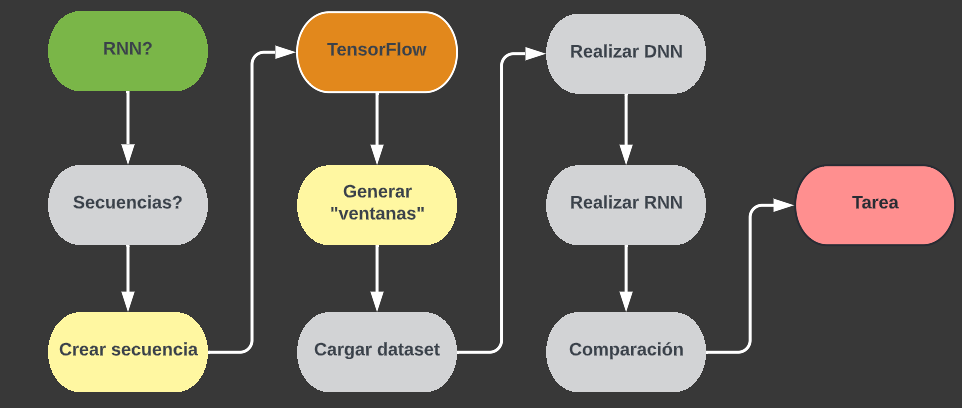

# 1 Crear secuencia

## 1.1 Señal 

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [75]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:
      for series_num in series:
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      plt.plot(time[start:end], series[start:end], format)

    plt.xlabel("Time")
    plt.ylabel("Valor")
    plt.grid(True)
    plt.show()

def trend(time, slope=0):
    series = slope * time
    return series

def seasonal_pattern(season_time):
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    data_pattern = amplitude * seasonal_pattern(season_time)
    return data_pattern

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    noise = rnd.randn(len(time)) * noise_level
    return noise


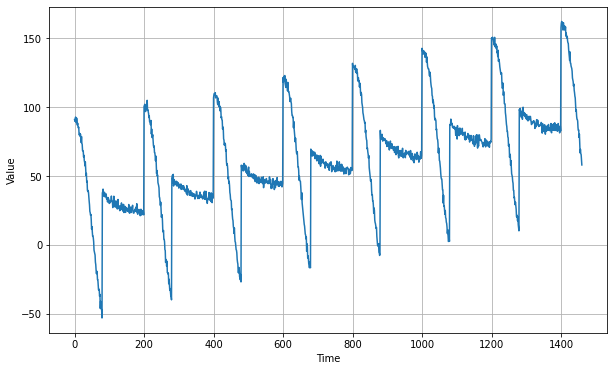

In [76]:
# Modificar parametros para cambiar la morfologia de la serie temporal
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 80
slope = 0.05
noise_level = 2

# Crear la serie
series = baseline + trend(time, slope) + seasonality(time, period=200, amplitude=amplitude)

# Agregar ruido
series += noise(time, noise_level, seed=50)

# Graficar la serie
plot_series(time, series)

In [ ]:
#Separar datos de TRAIN y TEST

# muestra en la que se realiza el recorte
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]


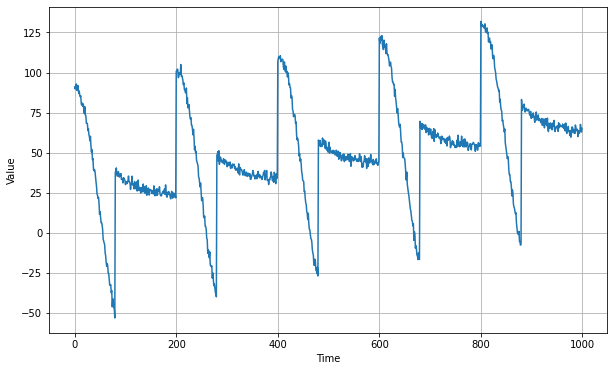

In [78]:
# Graficar la data de entrenamiento
plot_series(time_train, x_train)

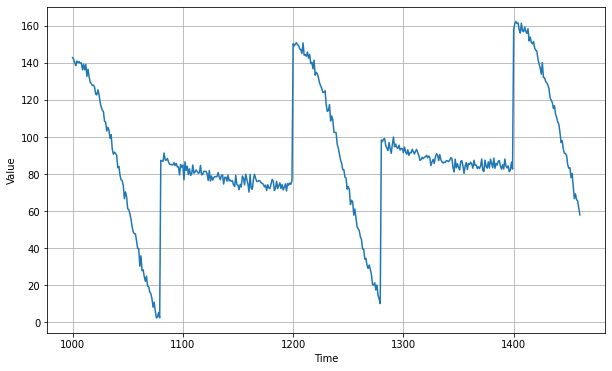

In [79]:
# Graficar la data de validación
plot_series(time_valid, x_valid)

## 1.2 Ventanear

In [80]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    dataset = tf.data.Dataset.from_tensor_slices(series) # Generamos un dataset de TF
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
   
    return dataset


In [81]:
# Definir parametros
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# 2 Enfoque no secuencial

## 2.1 DNN

In [82]:
# Definir modelos
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
                                    tf.keras.layers.Dense(1)])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


In [83]:
# Compilar y entrenar !! 
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

# https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 3838.1897
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 343.5903
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 226.3224
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 195.0039
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 177.8156
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 167.1838
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 157.1629
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 149.8557
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 142.9762
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 137.1402
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 131.9607
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 127.0650
Epoch 13/100

In [84]:
#Vamos a predecir y almacenar la predicciones en ORDEN
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]


length of the forecast list: 461
shape of the validation set: (461,)


shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


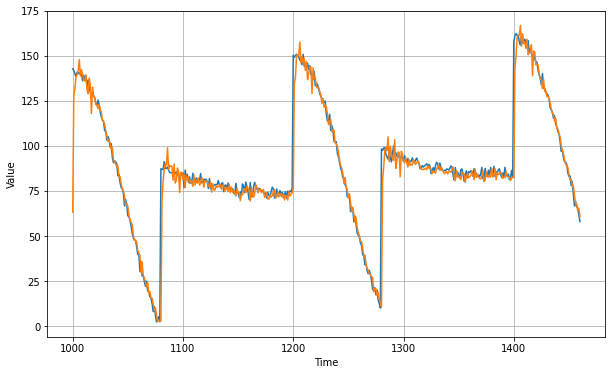

In [85]:
# Graficar serie + predicción
results = np.array(forecast).squeeze() #disminuimos dimensión
plot_series(time_valid, (x_valid, results))

In [86]:
# Metricas
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

86.10262
3.7765298


## 2.2 Random forest

In [87]:
# TAREA

# 3 RNN 

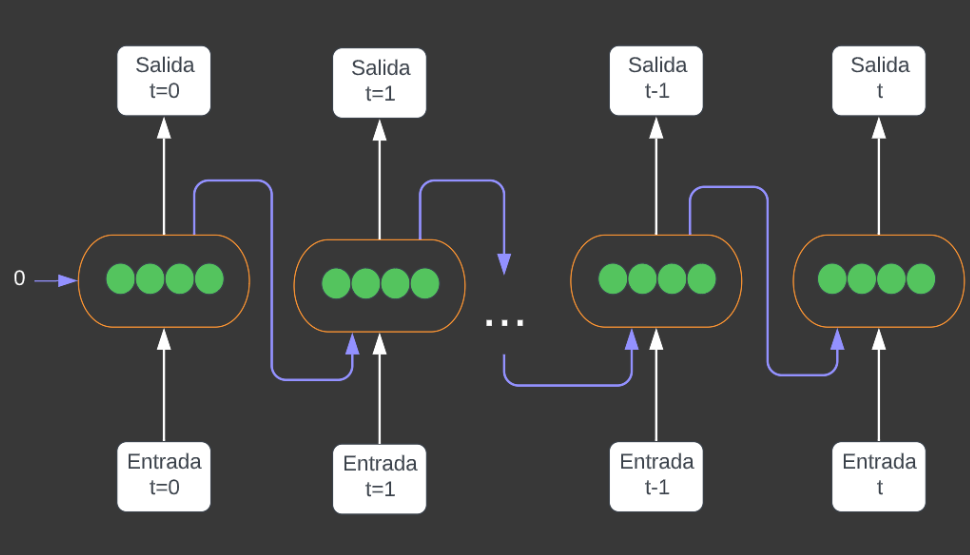

In [106]:
# Definir el modelo
model = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(40, return_sequences=False,input_shape=[None,1]),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,
              metrics=["mae"])

# ENTRENAR
history = model.fit(dataset,epochs=100)

# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD (Gradient descent (with momentum) optimizer)
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/Huber


Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 52.0341 - mae: 52.5338
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 50.6095 - mae: 51.1094
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 48.8832 - mae: 49.3822
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 47.3879 - mae: 47.8866
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 46.2307 - mae: 46.7291
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 45.0874 - mae: 45.5860
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 43.9529 - mae: 44.4520
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 42.8365 - mae: 43.3345
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 41.7311 - mae: 42.2301
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 40.6486 - mae: 41.1468
Epoch 11/100
31/31 [===================

In [120]:
#Vamos a predecir y almacenar la predicciones en ORDEN
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]


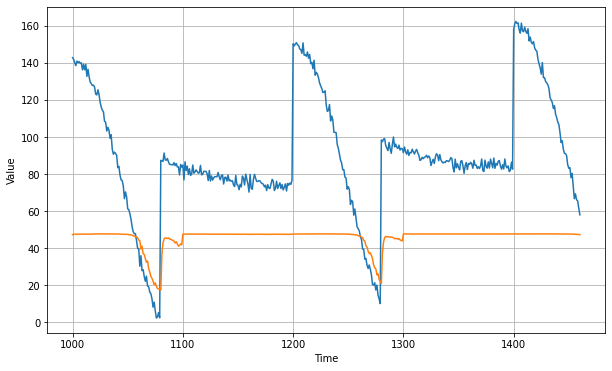

In [124]:
#PLOTEAR SEÑAL ORIGINAL Y PREDICCIÓN
results = np.array(forecast).squeeze() #bajamos la dimensión
plot_series(time_valid, (x_valid, results))

In [102]:
# Metricas
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

1474.238
28.450819


# 4 Deep RNN 

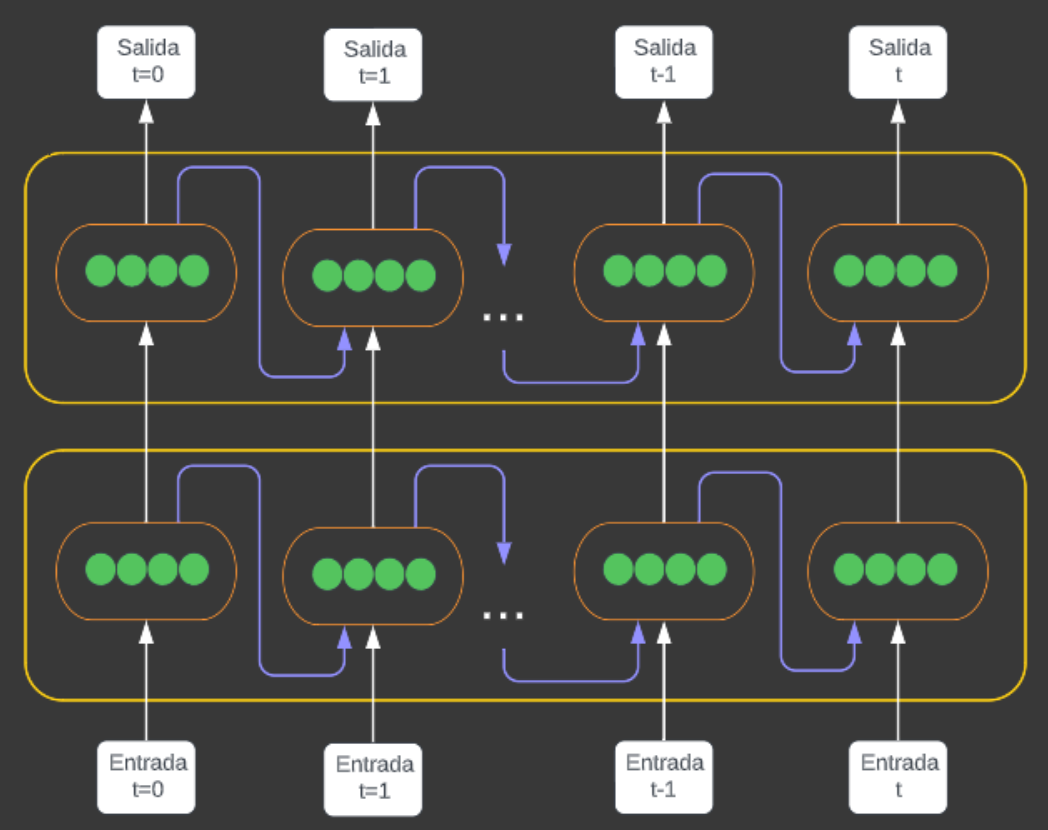

In [115]:
# Definir el modelo
model = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(40, return_sequences=True,input_shape=[None,1]),
  tf.keras.layers.SimpleRNN(40, return_sequences=False),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Entrenar
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 4s 11ms/step - loss: 50.7351 - mae: 51.2349
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 50.1861 - mae: 50.6858
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 49.7818 - mae: 50.2812
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 49.3405 - mae: 49.8392
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 48.7400 - mae: 49.2379
Epoch 6/100
31/31 [==============================] - 0s 12ms/step - loss: 48.1274 - mae: 48.6259
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 47.6594 - mae: 48.1588
Epoch 8/100
31/31 [==============================] - 0s 10ms/step - loss: 47.2115 - mae: 47.7109
Epoch 9/100
31/31 [==============================] - 0s 11ms/step - loss: 46.7587 - mae: 47.2577
Epoch 10/100
31/31 [==============================] - 0s 10ms/step - loss: 46.2982 - mae: 46.7973
Epoch 11/100
31/31 [=========

In [116]:
#Vamos a predecir y almacenar la predicciones en ORDEN
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]

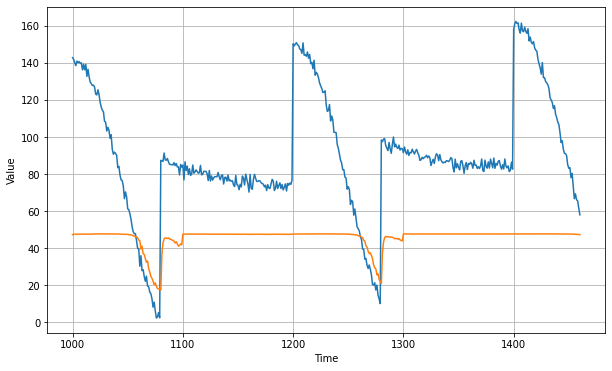

In [117]:
# Graficamos ambas señales

results = np.array(forecast).squeeze() #disminuimos dimensión
plot_series(time_valid, (x_valid, results))

In [110]:
# Metricas
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

2016.5492
36.311504


TAREA:



*   Probar Random forest
*   Mejorar metricas
*   tip: Ver learning rate



